In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc
from code.generate_data import SinteticData
from code.representation import *
from code.utils import *
from code.learning_models import *
from code.baseline import RaykarMC,LabelInference
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

import matplotlib
font = {'family' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

matplotlib.rc('axes', titlesize=25)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=25)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
ms = 10 #markersize

to_check = [100,2000,5000,10000,15000,25000,40000]
to_check

Using TensorFlow backend.


[100, 2000, 5000, 10000, 15000, 25000, 40000]

100
2000
5000
10000
15000
25000
40000
CIFAR example 50k exaples, 10 classes -- memory consume of representation


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


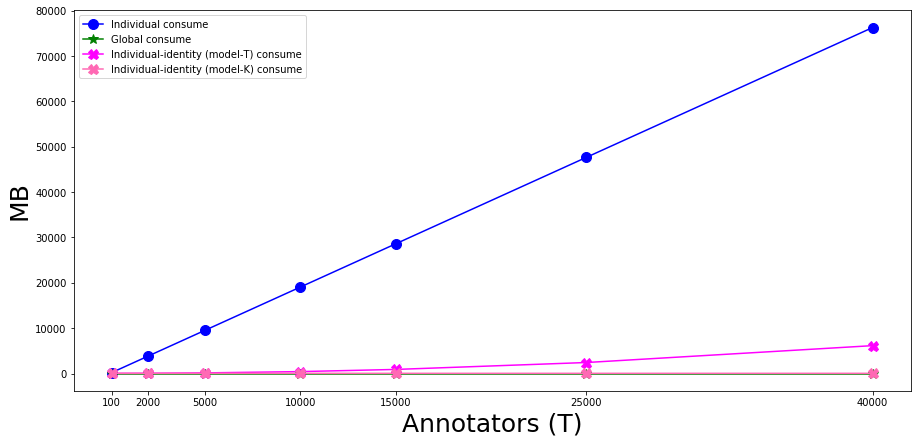

In [2]:
memory_cons = []
ours_consume_I = []
ours_consume_I3 = []

N = 50000
K = 10
T_i = 20
for t in to_check:
    print(t)
    a = np.zeros((N,t,K),dtype='float32') #int8
    memory_cons.append(a.nbytes/(1024*1024)) #MB
    
    t_aux = np.zeros((t,t),dtype='float32') #ann representation
    ours_consume_I.append( t_aux.nbytes/(1024*1024) )
    
    t_aux = np.zeros((t,K),dtype='float32') #ann representation
    ours_consume_I3.append( t_aux.nbytes/(1024*1024) )
    #ours_consume2.append( N*T_i*t_aux.nbytes/(1024*1024) ) #identity consume
    del a, t_aux
    gc.collect()

ours_consume = np.zeros((N,K),dtype='float32').nbytes/(1024*1024) #global
ours_consume_I = np.asarray(ours_consume_I)
ours_consume_I += np.zeros((N,T_i,K),dtype='float32').nbytes/(1024*1024) #annotations
ours_consume_I += np.zeros((N,T_i),dtype='float32').nbytes/(1024*1024) #identity

ours_consume_I3 = np.asarray(ours_consume_I3)
ours_consume_I3 += np.zeros((N,T_i,K),dtype='float32').nbytes/(1024*1024) #annotations
ours_consume_I3 += np.zeros((N,T_i),dtype='float32').nbytes/(1024*1024) #identity

print("CIFAR example 50k exaples, 10 classes -- memory consume of representation")

plt.figure(figsize=(15,7))
plt.plot(to_check,memory_cons,'bo-',label="Individual consume", markersize=ms)
plt.plot(to_check,np.tile(ours_consume,len(to_check)),'g*-',label="Global consume", markersize=ms)
plt.plot(to_check, ours_consume_I,'X-',label="Individual-identity (model-T) consume",color='magenta', markersize=ms)
plt.plot(to_check, ours_consume_I3,'X-',label="Individual-identity (model-K) consume",color='hotpink', markersize=ms)

#plt.hlines(16000,0,to_check[-1], color='r', label="Our memory limit")

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("Annotators (T)")
plt.legend()
plt.show()

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
N = Z_train.shape[0]
GenerateData = SinteticData(state=None)

#CONFUSION MATRIX CHOOSE
GenerateData.set_probas(asfile=True,file_matrix='./synthetic/simple/matrix_datasim_normal.csv',file_groups ='./synthetic/simple/groups_datasim_normal.csv')

#GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

In [4]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [5]:
to_check = [100,2000,5000,10000,15000,25000,40000]
T_data = 10 
M_seted = 5
BATCH_SIZE= 64

annot_acc = []
raykar_exec = []
raykar_init = []
ourglobal_exec = []
ourglobal_init = []
ourindiv1_exec = []
ourindiv1_init = []
ourindiv2_exec = []
ourindiv2_init = []
ourindiv3_exec = []
ourindiv3_init = []
mv_exec = []
ds_exec = []
for Tmax in to_check:
    aux_annot_acc = []
    aux_raykar_exec = []
    aux_raykar_init = []
    aux_ourglobal_exec = []
    aux_ourglobal_init = []
    aux_ourindiv1_exec = []
    aux_ourindiv1_init = []
    aux_ourindiv2_exec = []
    aux_ourindiv2_init = []
    aux_ourindiv3_exec = []
    aux_ourindiv3_init = []
    aux_mv_exec = []
    aux_ds_exec = []
    for _ in range(10):
        y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)
        T = y_obs.shape[1]
        #annot_acc.append(np.mean(GenerateData.yo_label == Z_train))

        #----------------------------RAYKAR---------------------------#
        y_obs_categorical = set_representation(y_obs,'onehot') 
        raykarMC = RaykarMC(X_train.shape[1:],y_obs_categorical.shape[-1],Tmax,epochs=1)
        raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)
        logL_hists,i = raykarMC.multiples_run(1,X_train,y_obs_categorical,max_iter=5,batch_size=BATCH_SIZE)

        aux_raykar_exec.append(raykarMC.current_exectime)
        aux_raykar_init.append(raykarMC.init_exectime)

        del raykarMC
        gc.collect()
        keras.backend.clear_session()
        #----------------------------RAYKAR---------------------------#

        #----------------------------Ours Global---------------------------#
        r_obs = set_representation(y_obs,"repeat")
        K = r_obs.shape[1]
        gMixture_Global = GroupMixtureGlo(X_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1) 
        gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
        logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,max_iter=5, batch_size=BATCH_SIZE)

        aux_ourglobal_exec.append(gMixture_Global.current_exectime)
        aux_ourglobal_init.append(gMixture_Global.init_exectime)
    
        del gMixture_Global
        gc.collect()
        keras.backend.clear_session()
        #----------------------------Ours Global---------------------------#
        
        #----------------------------Ours Individual---------------------------#
        Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
        T_idx_unique = np.arange(T).reshape(-1,1)
        A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
        A_rep = np.zeros((T, K))
        for i in range(N):
            for l, t_idx in enumerate(T_idx[i]):
                obs_t = Y_ann_train[i][l].argmax(axis=-1)
                A_rep[t_idx, obs_t] += 1
        gMixture_Ind = GroupMixtureInd(X_train.shape[1:],Kl=K,M=M_seted,epochs=1) 
        gMixture_Ind.define_model("mlp",16,1,BatchN=False,drop=0.2)
        gMixture_Ind.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)
        
        logL_hists,i = gMixture_Ind.multiples_run(1,X_train,Y_ann_train, T_idx, A=[],max_iter=5,
                                                  pre_init_g=0, pre_init_z= 3, batch_size=BATCH_SIZE)
        
        aux_ourindiv1_exec.append(gMixture_Ind.current_exectime)
        aux_ourindiv1_init.append(gMixture_Ind.init_exectime)
        
        del gMixture_Ind
        gc.collect()
        keras.backend.clear_session()

        gMixture_Ind = GroupMixtureInd(X_train.shape[1:],Kl=K,M=M_seted,epochs=1) 
        gMixture_Ind.define_model("mlp",16,1,BatchN=False,drop=0.2) 
        logL_hists,i_r = gMixture_Ind.multiples_run(1,X_train,Y_ann_train, T_idx, A=[],
                                                    pre_init_z=3,batch_size=BATCH_SIZE,max_iter=5)
        
        aux_ourindiv2_exec.append(gMixture_Ind.current_exectime)
        aux_ourindiv2_init.append(gMixture_Ind.init_exectime)
        
        del gMixture_Ind
        gc.collect()
        keras.backend.clear_session()

        gMixture_Ind = GroupMixtureInd(X_train.shape[1:],Kl=K,M=M_seted,epochs=1) 
        gMixture_Ind.define_model("mlp",16,1,BatchN=False,drop=0.2) 
        #gMixture_Ind.define_model_group("mlp", T, K*M_seted, 1, BatchN=False, embed=True, embed_M=A_rep) 
        gMixture_Ind.define_model_group("mlp", A_rep.shape[1], K*M_seted, 1, BatchN=False, embed=False) #con BN

        logL_hists,i_r = gMixture_Ind.multiples_run(1,X_train,Y_ann_train, T_idx, A=A_rep,
                                                    pre_init_g=0, pre_init_z=3, batch_size=BATCH_SIZE,max_iter=5)
        
        aux_ourindiv3_exec.append(gMixture_Ind.current_exectime)
        aux_ourindiv3_init.append(gMixture_Ind.init_exectime)
        
        del gMixture_Ind
        gc.collect()
        keras.backend.clear_session()
        #----------------------------Ours Individual---------------------------#
        
        #----------------------------Majority Voting---------------------------#
        mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
        time_callback = TimeHistory()
        model_mvsoft = MLP_Keras(X_train.shape[1:],mv_soft.shape[1],16,1,BN=False,drop=0.2)
        model_mvsoft.compile(loss='categorical_crossentropy',optimizer='adam')
        model_mvsoft.fit(X_train, mv_soft, epochs=5,batch_size=BATCH_SIZE,verbose=1,callbacks=[time_callback])
        times = time_callback.times
        aux_mv_exec.append(times[-1])
        del model_mvsoft
        gc.collect()
        keras.backend.clear_session()
        #----------------------------Majority Voting---------------------------#
        
        #----------------------------Dawid and Skene---------------------------#
        label_I = LabelInference(y_obs,1e-10, type_inf = 'ds', max_iter=5)
        ds_labels,ds_conf = label_I.DS_labels()
        aux_ds_exec.append(label_I.DS_current_exectime)
        del label_I
        gc.collect()
        #----------------------------Dawid and Skene---------------------------#
        
    raykar_exec.append(np.mean(aux_raykar_exec))
    raykar_init.append(np.mean(aux_raykar_init))
    ourglobal_exec.append(np.mean(aux_ourglobal_exec))
    ourglobal_init.append(np.mean(aux_ourglobal_init))
    ourindiv1_exec.append(np.mean(aux_ourindiv1_exec))
    ourindiv1_init.append(np.mean(aux_ourindiv1_init))
    ourindiv2_exec.append(np.mean(aux_ourindiv2_exec))
    ourindiv2_init.append(np.mean(aux_ourindiv2_init))
    ourindiv3_exec.append(np.mean(aux_ourindiv3_exec))
    ourindiv3_init.append(np.mean(aux_ourindiv3_init))
    mv_exec.append(np.mean(aux_mv_exec))
    ds_exec.append(np.mean(aux_ds_exec))
    
raykar_exec = np.asarray(raykar_exec)
raykar_init = np.asarray(raykar_init)
ourglobal_exec = np.asarray(ourglobal_exec)
ourglobal_init = np.asarray(ourglobal_init)
ourindiv1_exec = np.asarray(ourindiv1_exec)
ourindiv1_init = np.asarray(ourindiv1_init)
ourindiv2_exec = np.asarray(ourindiv2_exec)
ourindiv2_init = np.asarray(ourindiv2_init)
ourindiv3_exec = np.asarray(ourindiv3_exec)
ourindiv3_init = np.asarray(ourindiv3_init)
mv_exec = np.asarray(mv_exec)
ds_exec = np.asarray(ds_exec)
print("Done")

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.65 sec)	logL: -18015.570	
Iter 2/5 
M step: done,  E step: done //  (in 0.07 sec)	logL: -16533.436	Tol1: 0.08227	Tol2: 0.28463	
Iter 3/5 
M step: done,  E step: done //  (in 0.08 sec)	logL: -16050.674	Tol1: 0.02920	Tol2: 0.10517	
Iter 4/5 
M step: done,  E step: done //  (in 0.07 sec)	logL: -15786.832	Tol1: 0.01644	Tol2: 0.05096	
Iter 5/5 
M step: done,  E step: done //  (in 0.06 sec)	logL: -15598.643	Tol1: 0.01192	Tol2: 0.02355	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002806 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.54 sec)	logL: -24672.384	
Iter 2/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -23830.816	

M step: done,  E step: done //  (in 0.26 sec)	logL: -21874.145	Tol1: 0.02661	Tol2: 0.03137	
Iter 4/5
M step: done,  E step: done //  (in 0.26 sec)	logL: -21442.758	Tol1: 0.01972	Tol2: 0.02944	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 80us/step - loss: 1.0974
Epoch 2/5
2457/2457 [==============================] - 0s 21us/step - loss: 1.0152
Epoch 3/5
2457/2457 [==============================] - 0s 22us/step - loss: 0.9610
Epoch 4/5
2457/2457 [==============================] - 0s 26us/step - loss: 0.9227
Epoch 5/5
2457/2457 [==============================] - 0s 29us/step - loss: 0.8928
Representation for DS in 0.066397 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -18286.94734021036
2 	 -17088.534971567227 	0.3667	0.266854	0.065534
3 	 -16801.27515751495 	0.0913	0.204991	0.016810
4 	 -16724.855979778462 	0.0437	0.151597	0.004548
5 	 -16706.25187546173 	0.0311	0.093362	0.001112
6 	 -16699.908695004062 	0.0202	0.058998	0.000380
Class marginals
[

M step: done,  E step: done //  (in 0.63 sec)	logL: -20249.882	
Iter 2/5
M step: done,  E step: done //  (in 0.13 sec)	logL: -19368.289	Tol1: 0.04354	Tol2: 0.15549	
Iter 3/5
M step: done,  E step: done //  (in 0.13 sec)	logL: -18657.205	Tol1: 0.03671	Tol2: 0.15164	
Iter 4/5
M step: done,  E step: done //  (in 0.13 sec)	logL: -18101.705	Tol1: 0.02977	Tol2: 0.14301	
Iter 5/5
M step: done,  E step: done //  (in 0.13 sec)	logL: -17649.826	Tol1: 0.02496	Tol2: 0.12527	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000259 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24441, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.10 sec)	logL: -22528.865	
Iter 2/5
M step: done,  E step: done //  (in 0.29 sec)	logL: -20973.715	Tol1: 0.06903	Tol2: 37.24810	
Iter 3/5
M step: done,  E st

M step: done,  E step: done //  (in 0.06 sec)	logL: -21210.305	Tol1: 0.02509	Tol2: 0.20310	Tol3: 0.05660	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001240 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24657, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.33 sec)	logL: -24224.795	
Iter 2/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -23221.010	Tol1: 0.04144	Tol2: 0.16588	
Iter 3/5
M step: done,  E step: done //  (in 0.29 sec)	logL: -22342.730	Tol1: 0.03782	Tol2: 0.14654	
Iter 4/5
M step: done,  E step: done //  (in 0.34 sec)	logL: -21457.977	Tol1: 0.03960	Tol2: 0.15104	
Iter 5/5
M step: done,  E step: done //  (in 0.32 sec)	logL: -20654.623	Tol1: 0.03744	Tol2: 0.15494	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A

M step: done,  E step: done //  (in 0.48 sec)	logL: -18519.818	
Iter 2/5 
M step: done,  E step: done //  (in 0.07 sec)	logL: -16908.523	Tol1: 0.08700	Tol2: 0.27820	
Iter 3/5 
M step: done,  E step: done //  (in 0.06 sec)	logL: -16357.697	Tol1: 0.03258	Tol2: 0.10927	
Iter 4/5 
M step: done,  E step: done //  (in 0.06 sec)	logL: -16058.771	Tol1: 0.01827	Tol2: 0.04958	
Iter 5/5 
M step: done,  E step: done //  (in 0.06 sec)	logL: -15854.502	Tol1: 0.01272	Tol2: 0.01981	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002606 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.56 sec)	logL: -24877.157	
Iter 2/5
M step: done,  E step: done //  (in 0.09 sec)	logL: -24292.699	Tol1: 0.02349	Tol2: 0.33926	Tol3: 0.02604	
Iter 3/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -23781.969	Tol1: 0.02102

M step: done,  E step: done //  (in 0.24 sec)	logL: -21076.792	Tol1: 0.03373	Tol2: 0.03685	
Iter 5/5
M step: done,  E step: done //  (in 0.23 sec)	logL: -20583.987	Tol1: 0.02338	Tol2: 0.03512	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 94us/step - loss: 0.9903
Epoch 2/5
2457/2457 [==============================] - 0s 26us/step - loss: 0.9253
Epoch 3/5
2457/2457 [==============================] - 0s 23us/step - loss: 0.8932
Epoch 4/5
2457/2457 [==============================] - 0s 23us/step - loss: 0.8712
Epoch 5/5
2457/2457 [==============================] - 0s 21us/step - loss: 0.8551
Representation for DS in 0.059082 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -18482.49643718204
2 	 -17248.497438420392 	0.3422	0.275630	0.066766
3 	 -16992.271182535198 	0.0748	0.205462	0.014855
4 	 -16932.18287224636 	0.0407	0.141278	0.003536
5 	 -16914.987001057212 	0.0283	0.089026	0.001016
6 	 -16908.426443977656 	0.0194	0.052113	0.000388
Class marginals


M step: done,  E step: done //  (in 0.74 sec)	logL: -19648.067	
Iter 2/5
M step: done,  E step: done //  (in 0.31 sec)	logL: -18614.240	Tol1: 0.05262	Tol2: 0.19812	
Iter 3/5
M step: done,  E step: done //  (in 0.33 sec)	logL: -17851.425	Tol1: 0.04098	Tol2: 0.18911	
Iter 4/5
M step: done,  E step: done //  (in 0.29 sec)	logL: -17338.248	Tol1: 0.02875	Tol2: 0.16000	
Iter 5/5
M step: done,  E step: done //  (in 0.29 sec)	logL: -17009.101	Tol1: 0.01898	Tol2: 0.12079	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000224 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24706, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.02 sec)	logL: -23353.749	
Iter 2/5
M step: done,  E step: done //  (in 0.28 sec)	logL: -22264.712	Tol1: 0.04663	Tol2: 0.16456	
Iter 3/5
M step: done,  E ste

M step: done,  E step: done //  (in 0.06 sec)	logL: -21931.529	Tol1: 0.03322	Tol2: 0.17485	Tol3: 0.03735	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001273 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24695, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.46 sec)	logL: -22430.017	
Iter 2/5
M step: done,  E step: done //  (in 0.41 sec)	logL: -21039.706	Tol1: 0.06198	Tol2: 0.19584	
Iter 3/5
M step: done,  E step: done //  (in 0.40 sec)	logL: -20028.796	Tol1: 0.04805	Tol2: 0.19998	
Iter 4/5
M step: done,  E step: done //  (in 0.41 sec)	logL: -19216.735	Tol1: 0.04054	Tol2: 0.19391	
Iter 5/5
M step: done,  E step: done //  (in 0.45 sec)	logL: -18565.259	Tol1: 0.03390	Tol2: 0.17446	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A

M step: done,  E step: done //  (in 0.57 sec)	logL: -19963.711	
Iter 2/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -18180.957	Tol1: 0.08930	Tol2: 0.12922	
Iter 3/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -17375.176	Tol1: 0.04432	Tol2: 0.06340	
Iter 4/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -16946.969	Tol1: 0.02464	Tol2: 0.03448	
Iter 5/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -16667.141	Tol1: 0.01651	Tol2: 0.02100	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002122 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.50 sec)	logL: -26051.422	
Iter 2/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -25038.969	Tol1: 0.03886	Tol2: 0.38756	Tol3: 0.07606	
Iter 3/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -24462.632	Tol1: 0.02302

M step: done,  E step: done //  (in 0.27 sec)	logL: -19489.499	Tol1: 0.04143	Tol2: 0.21514	
Iter 5/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -18845.752	Tol1: 0.03303	Tol2: 0.18339	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 101us/step - loss: 0.9612
Epoch 2/5
2457/2457 [==============================] - 0s 33us/step - loss: 0.9062
Epoch 3/5
2457/2457 [==============================] - 0s 30us/step - loss: 0.8747
Epoch 4/5
2457/2457 [==============================] - 0s 28us/step - loss: 0.8566
Epoch 5/5
2457/2457 [==============================] - 0s 33us/step - loss: 0.8442
Representation for DS in 0.098576 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -15767.619418849035
2 	 -13467.392116367133 	0.3620	0.344563	0.145883
3 	 -12978.299513659906 	0.0421	741.023682	0.036317
4 	 -12837.204127445246 	0.0203	4629.823730	0.010872
5 	 -12791.310650673344 	0.0091	1481.560669	0.003575
6 	 -12769.174189989251 	0.0043	3703.747314	0.001731
Cl

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24635, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.84 sec)	logL: -19658.987	
Iter 2/5
M step: done,  E step: done //  (in 0.31 sec)	logL: -18558.921	Tol1: 0.05596	Tol2: 0.21269	
Iter 3/5
M step: done,  E step: done //  (in 0.29 sec)	logL: -17727.424	Tol1: 0.04480	Tol2: 0.20676	
Iter 4/5
M step: done,  E step: done //  (in 0.28 sec)	logL: -17168.771	Tol1: 0.03151	Tol2: 0.17678	
Iter 5/5
M step: done,  E step: done //  (in 0.29 sec)	logL: -16845.917	Tol1: 0.01880	Tol2: 0.13440	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000307 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24635, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.02 sec)	logL: -23646.475	
Iter 2/

M step: done,  E step: done //  (in 0.06 sec)	logL: -23097.058	Tol1: 0.02886	Tol2: 0.15607	Tol3: 0.01790	
Iter 5/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -22399.388	Tol1: 0.03021	Tol2: 0.15945	Tol3: 0.02523	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001318 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24706, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.43 sec)	logL: -22501.636	
Iter 2/5
M step: done,  E step: done //  (in 0.40 sec)	logL: -21261.452	Tol1: 0.05512	Tol2: 0.18778	
Iter 3/5
M step: done,  E step: done //  (in 0.44 sec)	logL: -20265.524	Tol1: 0.04684	Tol2: 0.19308	
Iter 4/5
M step: done,  E step: done //  (in 0.44 sec)	logL: -19421.050	Tol1: 0.04167	Tol2: 0.19088	
Iter 5/5
M step: done,  E step: done //  (in 0.47 sec)	logL: -18746.3

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (5000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.78 sec)	logL: -20225.238	
Iter 2/5 
M step: done,  E step: done //  (in 0.18 sec)	logL: -18950.357	Tol1: 0.06303	Tol2: 0.07181	
Iter 3/5 
M step: done,  E step: done //  (in 0.18 sec)	logL: -18243.705	Tol1: 0.03729	Tol2: 0.04148	
Iter 4/5 
M step: done,  E step: done //  (in 0.18 sec)	logL: -17871.975	Tol1: 0.02038	Tol2: 0.02449	
Iter 5/5 
M step: done,  E step: done //  (in 0.16 sec)	logL: -17648.473	Tol1: 0.01251	Tol2: 0.01569	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002103 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.47 sec)	logL: -24605.452	
Iter 2/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -23733.165

M step: done,  E step: done //  (in 0.28 sec)	logL: -20956.562	Tol1: 0.05728	Tol2: 0.21656	
Iter 3/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -20065.023	Tol1: 0.04254	Tol2: 0.20557	
Iter 4/5
M step: done,  E step: done //  (in 0.27 sec)	logL: -19312.819	Tol1: 0.03749	Tol2: 0.19603	
Iter 5/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -18673.418	Tol1: 0.03311	Tol2: 0.17734	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 84us/step - loss: 1.0504
Epoch 2/5
2457/2457 [==============================] - 0s 28us/step - loss: 0.9733
Epoch 3/5
2457/2457 [==============================] - 0s 27us/step - loss: 0.9273
Epoch 4/5
2457/2457 [==============================] - 0s 25us/step - loss: 0.8952
Epoch 5/5
2457/2457 [==============================] - 0s 24us/step - loss: 0.8740
Representation for DS in 0.147907 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -12603.591654607913
2 	 -9861.63363782061 	0.3506	0.269473	0.217554
3 	 -9238.4168

Doing clustering...Done!
Get init alphas in 0.001437 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24599, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.07 sec)	logL: -20290.172	
Iter 2/5
M step: done,  E step: done //  (in 0.60 sec)	logL: -19662.803	Tol1: 0.03092	Tol2: 0.12772	
Iter 3/5
M step: done,  E step: done //  (in 0.59 sec)	logL: -19004.114	Tol1: 0.03350	Tol2: 0.13786	
Iter 4/5
M step: done,  E step: done //  (in 0.59 sec)	logL: -18320.395	Tol1: 0.03598	Tol2: 0.14993	
Iter 5/5
M step: done,  E step: done //  (in 0.58 sec)	logL: -17712.733	Tol1: 0.03317	Tol2: 0.15235	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000301 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (

M step: done,  E step: done //  (in 0.09 sec)	logL: -23374.029	Tol1: 0.03246	Tol2: 0.22254	Tol3: 0.03949	
Iter 4/5
M step: done,  E step: done //  (in 0.09 sec)	logL: -22596.109	Tol1: 0.03328	Tol2: 0.19124	Tol3: 0.04390	
Iter 5/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -21898.521	Tol1: 0.03087	Tol2: 0.18727	Tol3: 0.05073	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001418 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24458, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.73 sec)	logL: -22134.387	
Iter 2/5
M step: done,  E step: done //  (in 0.58 sec)	logL: -20718.624	Tol1: 0.06396	Tol2: 0.20903	
Iter 3/5
M step: done,  E step: done //  (in 0.57 sec)	logL: -19618.444	Tol1: 0.05310	Tol2: 0.21044	
Iter 4/5
M step: done,  E step: done //  (in 0.61 sec)	

6 	 -8889.266697934101 	0.0049	50332.468750	0.002758
Class marginals
[0.37 0.29 0.34]
Estimation for DS in 23.495797 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (5000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.71 sec)	logL: -20086.592	
Iter 2/5 
M step: done,  E step: done //  (in 0.16 sec)	logL: -18752.639	Tol1: 0.06641	Tol2: 0.07746	
Iter 3/5 
M step: done,  E step: done //  (in 0.16 sec)	logL: -18058.355	Tol1: 0.03702	Tol2: 0.04163	
Iter 4/5 
M step: done,  E step: done //  (in 0.16 sec)	logL: -17670.430	Tol1: 0.02148	Tol2: 0.02307	
Iter 5/5 
M step: done,  E step: done //  (in 0.17 sec)	logL: -17405.006	Tol1: 0.01502	Tol2: 0.01441	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002314 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done, 

M step: done,  E step: done //  (in 1.09 sec)	logL: -22372.393	
Iter 2/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -21060.967	Tol1: 0.05862	Tol2: 0.20657	
Iter 3/5
M step: done,  E step: done //  (in 0.23 sec)	logL: -20049.660	Tol1: 0.04802	Tol2: 0.20414	
Iter 4/5
M step: done,  E step: done //  (in 0.21 sec)	logL: -19115.851	Tol1: 0.04657	Tol2: 0.20766	
Iter 5/5
M step: done,  E step: done //  (in 0.23 sec)	logL: -18283.739	Tol1: 0.04353	Tol2: 0.20203	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 91us/step - loss: 1.1282
Epoch 2/5
2457/2457 [==============================] - 0s 24us/step - loss: 1.0193
Epoch 3/5
2457/2457 [==============================] - 0s 24us/step - loss: 0.9443
Epoch 4/5
2457/2457 [==============================] - 0s 23us/step - loss: 0.8954
Epoch 5/5
2457/2457 [==============================] - 0s 23us/step - loss: 0.8675
Representation for DS in 0.150386 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -12303.85

M step: done,  E step: done //  (in 0.99 sec)	logL: -17803.212	Tol1: 0.06079	Tol2: 0.21071	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001832 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24695, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.44 sec)	logL: -18727.783	
Iter 2/5
M step: done,  E step: done //  (in 0.97 sec)	logL: -17874.439	Tol1: 0.04557	Tol2: 0.17829	
Iter 3/5
M step: done,  E step: done //  (in 1.00 sec)	logL: -17175.623	Tol1: 0.03910	Tol2: 0.17719	
Iter 4/5
M step: done,  E step: done //  (in 0.93 sec)	logL: -16602.493	Tol1: 0.03337	Tol2: 0.16317	
Iter 5/5
M step: done,  E step: done //  (in 0.97 sec)	logL: -16193.191	Tol1: 0.02465	Tol2: 0.13605	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?

M step: done,  E step: done //  (in 0.54 sec)	logL: -24261.358	
Iter 2/5
M step: done,  E step: done //  (in 0.09 sec)	logL: -23193.155	Tol1: 0.04403	Tol2: 0.58575	Tol3: 0.12650	
Iter 3/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -22452.035	Tol1: 0.03195	Tol2: 0.27496	Tol3: 0.05720	
Iter 4/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -21805.457	Tol1: 0.02880	Tol2: 0.21974	Tol3: 0.05373	
Iter 5/5
M step: done,  E step: done //  (in 0.09 sec)	logL: -21340.963	Tol1: 0.02130	Tol2: 0.18531	Tol3: 0.04754	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002463 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24465, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.05 sec)	logL: -22871.193	
Iter 2/5
M step: done,  E step: done //  (in 0.88 sec)	logL: -21351.9

3 	 -6319.1766124786445 	0.0393	12424.312500	0.079867
4 	 -6129.700754331154 	0.0224	98778.093750	0.029984
5 	 -6050.748577139621 	0.0104	133066.531250	0.012880
6 	 -6001.561220315345 	0.0053	87743.382812	0.008129
Class marginals
[0.37 0.3  0.34]
Estimation for DS in 41.814390 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.86 sec)	logL: -20543.443	
Iter 2/5 
M step: done,  E step: done //  (in 0.25 sec)	logL: -19378.422	Tol1: 0.05671	Tol2: 0.05403	
Iter 3/5 
M step: done,  E step: done //  (in 0.24 sec)	logL: -18603.801	Tol1: 0.03997	Tol2: 0.03395	
Iter 4/5 
M step: done,  E step: done //  (in 0.28 sec)	logL: -18155.793	Tol1: 0.02408	Tol2: 0.01946	
Iter 5/5 
M step: done,  E step: done //  (in 0.28 sec)	logL: -17881.277	Tol1: 0.01512	Tol2: 0.01116	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init a

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24768, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.06 sec)	logL: -23869.063	
Iter 2/5
M step: done,  E step: done //  (in 0.26 sec)	logL: -21631.573	Tol1: 0.09374	Tol2: 0.25228	
Iter 3/5
M step: done,  E step: done //  (in 0.26 sec)	logL: -20120.619	Tol1: 0.06985	Tol2: 0.20923	
Iter 4/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -18868.404	Tol1: 0.06224	Tol2: 0.21059	
Iter 5/5
M step: done,  E step: done //  (in 0.26 sec)	logL: -17832.510	Tol1: 0.05490	Tol2: 0.20604	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 95us/step - loss: 1.0798
Epoch 2/5
2457/2457 [==============================] - 0s 28us/step - loss: 0.9907
Epoch 3/5
2457/2457 [==============================] - 0s 28us/step - loss: 0.9321
Epoch 4/5
2457/2457 [==============================] - 0s 29us/step - loss: 0.8900
Epoch 5/5
2457/2457 [==============================] - 0s 

M step: done,  E step: done //  (in 1.01 sec)	logL: -18267.212	Tol1: 0.07020	Tol2: 0.20794	
Iter 5/5
M step: done,  E step: done //  (in 0.98 sec)	logL: -16956.414	Tol1: 0.07176	Tol2: 0.22025	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001597 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24538, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.40 sec)	logL: -17594.462	
Iter 2/5
M step: done,  E step: done //  (in 0.99 sec)	logL: -16653.112	Tol1: 0.05350	Tol2: 0.18314	
Iter 3/5
M step: done,  E step: done //  (in 0.99 sec)	logL: -15907.274	Tol1: 0.04479	Tol2: 0.16944	
Iter 4/5
M step: done,  E step: done //  (in 0.93 sec)	logL: -15347.762	Tol1: 0.03517	Tol2: 0.14690	
Iter 5/5
M step: done,  E step: done //  (in 0.93 sec)	logL: -14981.997	Tol1: 0.02383	Tol2: 0.125

M step: done,  E step: done //  (in 0.47 sec)	logL: -24998.078	
Iter 2/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -24032.218	Tol1: 0.03864	Tol2: 0.60096	Tol3: 0.09798	
Iter 3/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -23344.176	Tol1: 0.02863	Tol2: 0.25987	Tol3: 0.05274	
Iter 4/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -22648.673	Tol1: 0.02979	Tol2: 0.19943	Tol3: 0.04829	
Iter 5/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -21982.252	Tol1: 0.02942	Tol2: 0.17900	Tol3: 0.04688	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002331 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24592, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.20 sec)	logL: -22239.499	
Iter 2/5
M step: done,  E step: done //  (in 1.00 sec)	logL: -20573.1

3 	 -5108.438225887625 	0.0472	8161.262695	0.091924
4 	 -4902.799887423466 	0.0179	98135.468750	0.040255
5 	 -4798.714543015572 	0.0147	130069.984375	0.021230
6 	 -4739.200299708792 	0.0065	98342.367188	0.012402
Class marginals
[0.37 0.28 0.34]
Estimation for DS in 54.519045 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (15000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.99 sec)	logL: -21091.824	
Iter 2/5 
M step: done,  E step: done //  (in 0.35 sec)	logL: -20190.676	Tol1: 0.04273	Tol2: 0.04132	
Iter 3/5 
M step: done,  E step: done //  (in 0.34 sec)	logL: -19391.061	Tol1: 0.03960	Tol2: 0.03061	
Iter 4/5 
M step: done,  E step: done //  (in 0.40 sec)	logL: -18823.127	Tol1: 0.02929	Tol2: 0.02043	
Iter 5/5 
M step: done,  E step: done //  (in 0.41 sec)	logL: -18443.605	Tol1: 0.02016	Tol2: 0.01298	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alp

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24459, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.13 sec)	logL: -19625.840	
Iter 2/5
M step: done,  E step: done //  (in 0.26 sec)	logL: -18015.334	Tol1: 0.08206	Tol2: 0.32441	
Iter 3/5
M step: done,  E step: done //  (in 0.24 sec)	logL: -16680.346	Tol1: 0.07410	Tol2: 0.20859	
Iter 4/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -15498.247	Tol1: 0.07087	Tol2: 0.18804	
Iter 5/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -14504.792	Tol1: 0.06410	Tol2: 0.16648	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 80us/step - loss: 1.0506
Epoch 2/5
2457/2457 [==============================] - 0s 22us/step - loss: 0.9697
Epoch 3/5
2457/2457 [==============================] - 0s 22us/step - loss: 0.9224
Epoch 4/5
2457/2457 [==============================] - 0s 21us/step - loss: 0.8898
Epoch 5/5
2457/2457 [==============================] - 0s 

M step: done,  E step: done //  (in 0.98 sec)	logL: -18298.877	Tol1: 0.07484	Tol2: 0.21452	
Iter 5/5
M step: done,  E step: done //  (in 1.18 sec)	logL: -16842.690	Tol1: 0.07958	Tol2: 0.22872	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002177 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24374, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.87 sec)	logL: -17583.991	
Iter 2/5
M step: done,  E step: done //  (in 1.22 sec)	logL: -16825.163	Tol1: 0.04315	Tol2: 0.17073	
Iter 3/5
M step: done,  E step: done //  (in 1.18 sec)	logL: -16212.076	Tol1: 0.03644	Tol2: 0.16086	
Iter 4/5
M step: done,  E step: done //  (in 1.43 sec)	logL: -15668.535	Tol1: 0.03353	Tol2: 0.15630	
Iter 5/5
M step: done,  E step: done //  (in 1.16 sec)	logL: -15235.544	Tol1: 0.02763	Tol2: 0.140

M step: done,  E step: done //  (in 0.50 sec)	logL: -24442.518	
Iter 2/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -23670.319	Tol1: 0.03159	Tol2: 0.39925	Tol3: 0.05091	
Iter 3/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -23066.143	Tol1: 0.02552	Tol2: 0.20458	Tol3: 0.00875	
Iter 4/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -22468.030	Tol1: 0.02593	Tol2: 0.17572	Tol3: 0.00718	
Iter 5/5
M step: done,  E step: done //  (in 0.09 sec)	logL: -21944.495	Tol1: 0.02330	Tol2: 0.16205	Tol3: 0.00635	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002491 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24492, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.53 sec)	logL: -22487.754	
Iter 2/5
M step: done,  E step: done //  (in 1.31 sec)	logL: -20898.2

3 	 -4957.505507008069 	0.0518	5790.483887	0.093866
4 	 -4769.643746556704 	0.0197	92041.914062	0.037894
5 	 -4675.589909822471 	0.0125	131580.593750	0.019719
6 	 -4628.974946780874 	0.0070	101235.445312	0.009970
Class marginals
[0.37 0.29 0.34]
Estimation for DS in 54.282846 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (15000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.99 sec)	logL: -20803.371	
Iter 2/5 
M step: done,  E step: done //  (in 0.32 sec)	logL: -19939.541	Tol1: 0.04152	Tol2: 0.03919	
Iter 3/5 
M step: done,  E step: done //  (in 0.40 sec)	logL: -19197.514	Tol1: 0.03721	Tol2: 0.02992	
Iter 4/5 
M step: done,  E step: done //  (in 0.36 sec)	logL: -18697.881	Tol1: 0.02603	Tol2: 0.01952	
Iter 5/5 
M step: done,  E step: done //  (in 0.37 sec)	logL: -18376.793	Tol1: 0.01717	Tol2: 0.01220	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init al

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24495, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.20 sec)	logL: -22702.442	
Iter 2/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -21043.342	Tol1: 0.07308	Tol2: 0.38611	
Iter 3/5
M step: done,  E step: done //  (in 0.28 sec)	logL: -19415.733	Tol1: 0.07735	Tol2: 0.24279	
Iter 4/5
M step: done,  E step: done //  (in 0.24 sec)	logL: -17569.537	Tol1: 0.09509	Tol2: 0.20218	
Iter 5/5
M step: done,  E step: done //  (in 0.24 sec)	logL: -15676.601	Tol1: 0.10774	Tol2: 0.18275	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 79us/step - loss: 1.2451
Epoch 2/5
2457/2457 [==============================] - 0s 21us/step - loss: 1.1291
Epoch 3/5
2457/2457 [==============================] - 0s 21us/step - loss: 1.0447
Epoch 4/5
2457/2457 [==============================] - 0s 21us/step - loss: 0.9848
Epoch 5/5
2457/2457 [==============================] - 0s 

M step: done,  E step: done //  (in 1.53 sec)	logL: -18513.521	Tol1: 0.08914	Tol2: 0.21793	
Iter 5/5
M step: done,  E step: done //  (in 1.43 sec)	logL: -16648.125	Tol1: 0.10076	Tol2: 0.25029	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002848 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24782, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.06 sec)	logL: -16269.087	
Iter 2/5
M step: done,  E step: done //  (in 1.54 sec)	logL: -15400.281	Tol1: 0.05340	Tol2: 0.19488	
Iter 3/5
M step: done,  E step: done //  (in 1.73 sec)	logL: -14757.950	Tol1: 0.04171	Tol2: 0.17867	
Iter 4/5
M step: done,  E step: done //  (in 1.63 sec)	logL: -14182.563	Tol1: 0.03899	Tol2: 0.16648	
Iter 5/5
M step: done,  E step: done //  (in 1.52 sec)	logL: -13708.829	Tol1: 0.03340	Tol2: 0.143

M step: done,  E step: done //  (in 0.49 sec)	logL: -24753.815	
Iter 2/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -23829.580	Tol1: 0.03734	Tol2: 0.43982	Tol3: 0.04410	
Iter 3/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -23141.736	Tol1: 0.02887	Tol2: 0.22823	Tol3: 0.02312	
Iter 4/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -22438.689	Tol1: 0.03038	Tol2: 0.19648	Tol3: 0.03243	
Iter 5/5
M step: done,  E step: done //  (in 0.09 sec)	logL: -21808.234	Tol1: 0.02810	Tol2: 0.18062	Tol3: 0.03753	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001660 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24694, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.64 sec)	logL: -22602.815	
Iter 2/5
M step: done,  E step: done //  (in 1.52 sec)	logL: -20438.5

3 	 -3824.0113356724623 	0.0757	2752.854736	0.102043
4 	 -3646.2080217787734 	0.0166	63565.019531	0.046497
5 	 -3555.1532839397296 	0.0125	112180.125000	0.024972
6 	 -3502.8942026847385 	0.0095	83344.398438	0.014700
Class marginals
[0.37 0.28 0.34]
Estimation for DS in 69.939993 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (25000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 1.12 sec)	logL: -20968.637	
Iter 2/5 
M step: done,  E step: done //  (in 0.37 sec)	logL: -20102.297	Tol1: 0.04132	Tol2: 0.03776	
Iter 3/5 
M step: done,  E step: done //  (in 0.39 sec)	logL: -19353.051	Tol1: 0.03727	Tol2: 0.02639	
Iter 4/5 
M step: done,  E step: done //  (in 0.38 sec)	logL: -18835.684	Tol1: 0.02673	Tol2: 0.01653	
Iter 5/5 
M step: done,  E step: done //  (in 0.38 sec)	logL: -18478.838	Tol1: 0.01895	Tol2: 0.01010	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24578, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.03 sec)	logL: -22404.371	
Iter 2/5
M step: done,  E step: done //  (in 0.22 sec)	logL: -18890.077	Tol1: 0.15686	Tol2: 0.30914	
Iter 3/5
M step: done,  E step: done //  (in 0.25 sec)	logL: -16955.645	Tol1: 0.10240	Tol2: 0.17994	
Iter 4/5
M step: done,  E step: done //  (in 0.26 sec)	logL: -15411.359	Tol1: 0.09108	Tol2: 0.15019	
Iter 5/5
M step: done,  E step: done //  (in 0.27 sec)	logL: -14159.634	Tol1: 0.08122	Tol2: 0.13708	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 93us/step - loss: 1.1031
Epoch 2/5
2457/2457 [==============================] - 0s 28us/step - loss: 1.0265
Epoch 3/5
2457/2457 [==============================] - 0s 28us/step - loss: 0.9694
Epoch 4/5
2457/2457 [==============================] - 0s 28us/step - loss: 0.9237
Epoch 5/5
2457/2457 [==============================] - 0s 

M step: done,  E step: done //  (in 1.56 sec)	logL: -16498.104	Tol1: 0.11216	Tol2: 0.23092	
Iter 5/5
M step: done,  E step: done //  (in 1.35 sec)	logL: -14563.102	Tol1: 0.11729	Tol2: 0.26631	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001586 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24221, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.07 sec)	logL: -14208.874	
Iter 2/5
M step: done,  E step: done //  (in 1.50 sec)	logL: -13583.338	Tol1: 0.04402	Tol2: 0.18074	
Iter 3/5
M step: done,  E step: done //  (in 1.53 sec)	logL: -13133.105	Tol1: 0.03315	Tol2: 0.15697	
Iter 4/5
M step: done,  E step: done //  (in 1.61 sec)	logL: -12742.584	Tol1: 0.02974	Tol2: 0.13648	
Iter 5/5
M step: done,  E step: done //  (in 1.48 sec)	logL: -12412.591	Tol1: 0.02590	Tol2: 0.117

M step: done,  E step: done //  (in 0.52 sec)	logL: -25642.335	
Iter 2/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -24518.807	Tol1: 0.04382	Tol2: 0.41488	Tol3: 0.07554	
Iter 3/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -23822.398	Tol1: 0.02840	Tol2: 0.19556	Tol3: 0.01888	
Iter 4/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -23160.364	Tol1: 0.02779	Tol2: 0.16067	Tol3: 0.01380	
Iter 5/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -22521.445	Tol1: 0.02759	Tol2: 0.16010	Tol3: 0.02021	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001810 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24520, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 3.19 sec)	logL: -23526.004	
Iter 2/5
M step: done,  E step: done //  (in 1.93 sec)	logL: -20921.3

3 	 -2944.8828416289557 	0.1027	1051.130005	0.108735
4 	 -2789.576287376996 	0.0298	31310.615234	0.052738
5 	 -2712.040403754722 	0.0077	81339.507812	0.027795
6 	 -2662.88917643233 	0.0048	77597.468750	0.018123
Class marginals
[0.38 0.27 0.35]
Estimation for DS in 80.235452 sec
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (40000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 1.32 sec)	logL: -20670.051	
Iter 2/5 
M step: done,  E step: done //  (in 0.60 sec)	logL: -19676.223	Tol1: 0.04808	Tol2: 0.03724	
Iter 3/5 
M step: done,  E step: done //  (in 0.54 sec)	logL: -18859.238	Tol1: 0.04152	Tol2: 0.02578	
Iter 4/5 
M step: done,  E step: done //  (in 0.52 sec)	logL: -18343.152	Tol1: 0.02737	Tol2: 0.01533	
Iter 5/5 
M step: done,  E step: done //  (in 0.53 sec)	logL: -18023.945	Tol1: 0.01740	Tol2: 0.00922	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alph

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24798, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.10 sec)	logL: -27447.816	
Iter 2/5
M step: done,  E step: done //  (in 0.26 sec)	logL: -24026.258	Tol1: 0.12466	Tol2: 0.63292	
Iter 3/5
M step: done,  E step: done //  (in 0.29 sec)	logL: -21640.156	Tol1: 0.09931	Tol2: 0.26161	
Iter 4/5
M step: done,  E step: done //  (in 0.27 sec)	logL: -19317.467	Tol1: 0.10733	Tol2: 0.18836	
Iter 5/5
M step: done,  E step: done //  (in 0.28 sec)	logL: -16837.875	Tol1: 0.12836	Tol2: 0.16941	
Finished training!
Epoch 1/5
2457/2457 [==============================] - 0s 98us/step - loss: 1.2410
Epoch 2/5
2457/2457 [==============================] - 0s 29us/step - loss: 1.1023
Epoch 3/5
2457/2457 [==============================] - 0s 29us/step - loss: 1.0237
Epoch 4/5
2457/2457 [==============================] - 0s 29us/step - loss: 0.9679
Epoch 5/5
2457/2457 [==============================] - 0s 

M step: done,  E step: done //  (in 2.07 sec)	logL: -16800.522	Tol1: 0.11413	Tol2: 0.23956	
Iter 5/5
M step: done,  E step: done //  (in 1.96 sec)	logL: -14696.220	Tol1: 0.12525	Tol2: 0.27285	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001736 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24778, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.34 sec)	logL: -13576.810	
Iter 2/5
M step: done,  E step: done //  (in 1.78 sec)	logL: -12715.920	Tol1: 0.06341	Tol2: 0.21257	
Iter 3/5
M step: done,  E step: done //  (in 1.82 sec)	logL: -12099.383	Tol1: 0.04849	Tol2: 0.18421	
Iter 4/5
M step: done,  E step: done //  (in 1.86 sec)	logL: -11669.277	Tol1: 0.03555	Tol2: 0.15224	
Iter 5/5
M step: done,  E step: done //  (in 1.78 sec)	logL: -11354.443	Tol1: 0.02698	Tol2: 0.123

M step: done,  E step: done //  (in 0.52 sec)	logL: -25288.411	
Iter 2/5
M step: done,  E step: done //  (in 0.10 sec)	logL: -24003.478	Tol1: 0.05081	Tol2: 0.49638	Tol3: 0.03980	
Iter 3/5
M step: done,  E step: done //  (in 0.10 sec)	logL: -23261.232	Tol1: 0.03092	Tol2: 0.18600	Tol3: 0.01672	
Iter 4/5
M step: done,  E step: done //  (in 0.10 sec)	logL: -22520.407	Tol1: 0.03185	Tol2: 0.15543	Tol3: 0.01399	
Iter 5/5
M step: done,  E step: done //  (in 0.09 sec)	logL: -21838.191	Tol1: 0.03029	Tol2: 0.16184	Tol3: 0.01418	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001600 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24386, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 3.48 sec)	logL: -22392.428	
Iter 2/5
M step: done,  E step: done //  (in 2.29 sec)	logL: -20039.9

3 	 -2937.1886850666247 	0.0878	879.581848	0.101983
4 	 -2786.789278090106 	0.0281	30104.613281	0.051205
5 	 -2705.3905475149973 	0.0124	74142.203125	0.029209
6 	 -2655.385011666956 	0.0097	74291.710938	0.018484
Class marginals
[0.37 0.27 0.36]
Estimation for DS in 81.329882 sec
Done


In [7]:
import pandas as pd
df = pd.DataFrame({"Raykar exec": raykar_exec, "Raykar init": raykar_init, "Our exec": ourglobal_exec,
                  "Our init": ourglobal_init, "MV exec": mv_exec, "DS exec": ds_exec, 
                   "Our Indiv1 exec" : ourindiv1_exec,  "Our Indiv1 init" : ourindiv1_init,
                  "Our Indiv2 exec" : ourindiv2_exec,  "Our Indiv2 init" : ourindiv2_init,
                  "Our Indiv3 exec" : ourindiv3_exec,  "Our Indiv3 init" : ourindiv3_init,})
df.to_csv("time_comparison_plus.csv",index=False)
df.head()

,DS exec,MV exec,Our Indiv1 exec,Our Indiv1 init,Our Indiv2 exec,Our Indiv2 init,Our Indiv3 exec,Our Indiv3 init,Our exec,Our init,Raykar exec,Raykar init
0,0.130148,0.068585,0.326656,0.855280,0.116812,0.939398,0.249273,0.825402,0.071913,0.145331,0.052984,0.005496
1,0.906973,0.065110,0.439890,0.805438,0.295618,0.899630,0.256550,0.808713,0.064326,0.134374,0.102000,0.093851
2,2.085635,0.062790,0.642733,0.874985,0.586328,0.955731,0.249853,0.864638,0.067207,0.135374,0.168043,0.242707
3,3.728982,0.067202,0.989064,0.980264,0.972534,0.984063,0.262675,0.852937,0.069292,0.147210,0.284358,0.427340
4,4.905641,0.071119,1.117269,0.974136,1.247862,0.934132,0.276543,0.841270,0.073339,0.147657,0.381043,0.563011


In [39]:
import pandas as pd
aux = pd.read_csv("time_comparison_plus.csv")
raykar_exec = aux["Raykar exec"]
raykar_init = aux["Raykar init"]
ourglobal_exec = aux["Our exec"]
ourglobal_init = aux["Our init"]
mv_exec = aux["MV exec"]
ds_exec = aux["DS exec"]
ourindiv1_exec = aux["Our Indiv1 exec"]
ourindiv1_init = aux["Our Indiv1 init"]
ourindiv2_exec = aux["Our Indiv2 exec"]
ourindiv2_init = aux["Our Indiv2 init"]
ourindiv3_exec = aux["Our Indiv3 exec"]
ourindiv3_init = aux["Our Indiv3 init"]

### Comparison between Ours Global (CMM) and Raykar

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


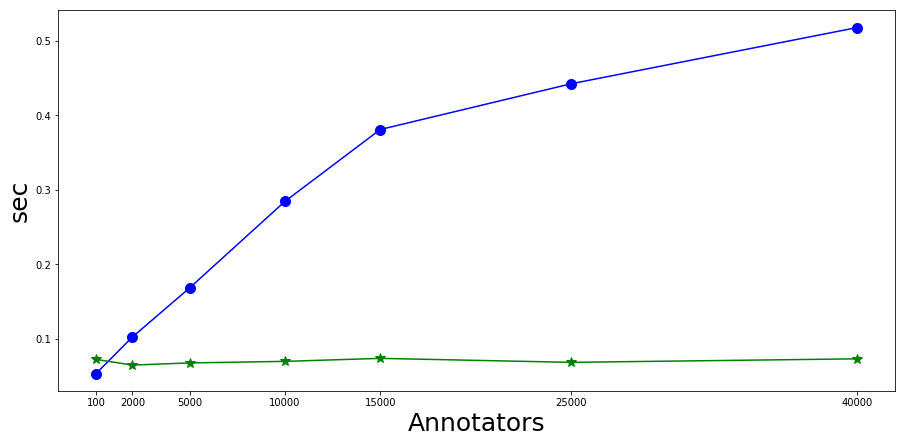

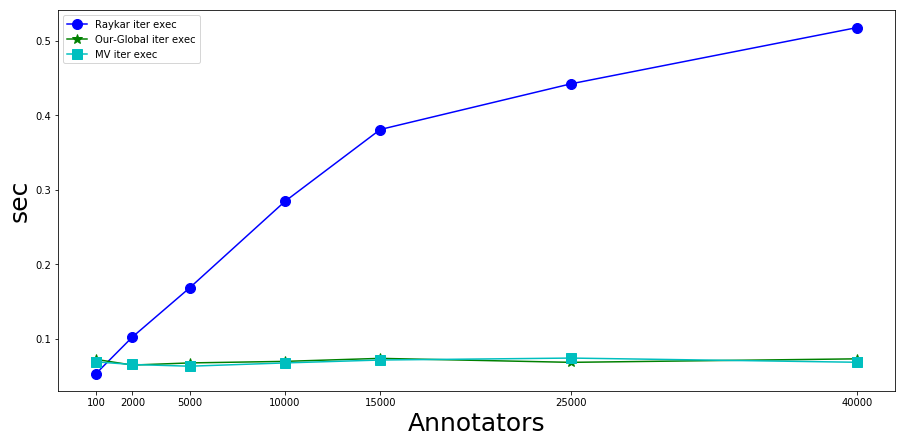

In [8]:
plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec", markersize=ms)
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec", markersize=ms)
#plt.plot(to_check,mv_exec,'cs-',label="MV iter exec", markersize=ms)
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
#plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec", markersize=ms)
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec", markersize=ms)
plt.plot(to_check,mv_exec,'cs-',label="MV iter exec", markersize=ms)
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

### Comparison between Alls -- Ours Global (CMM), Ours Individual and Raykar

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


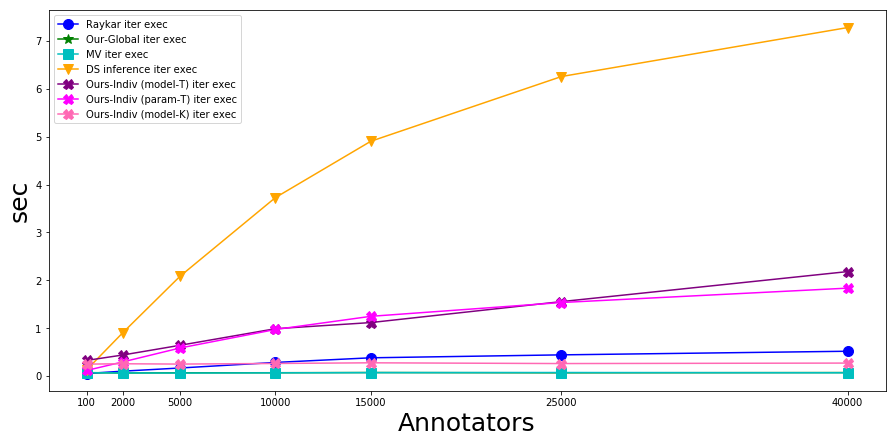

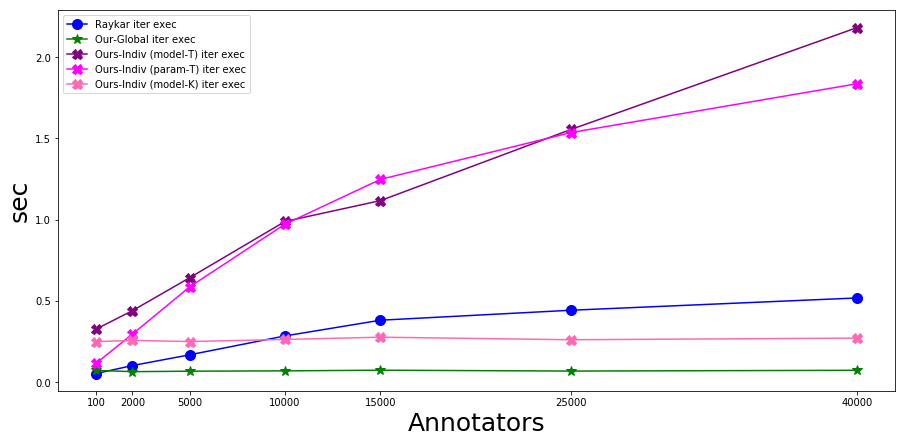

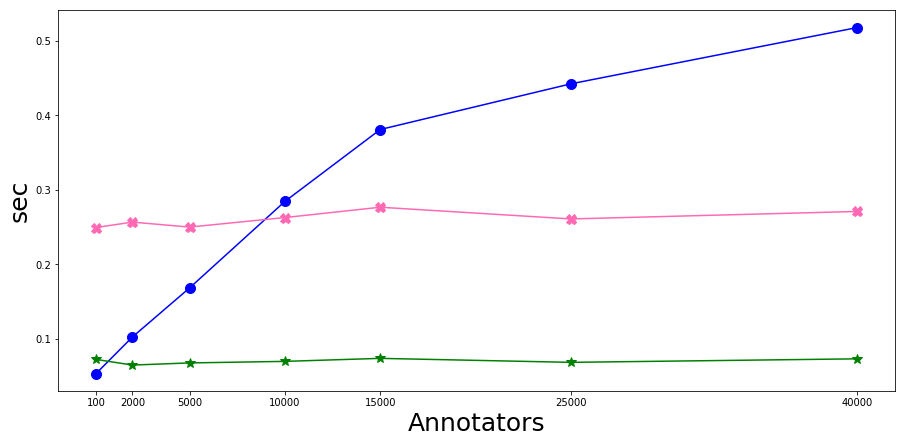

In [9]:
plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec", markersize=ms)
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec", markersize=ms)
plt.plot(to_check,mv_exec,'cs-',label="MV iter exec", markersize=ms)
plt.plot(to_check,ds_exec,'v-',label="DS inference iter exec", color='orange', markersize=ms)

plt.plot(to_check,ourindiv1_exec,'X-',label="Ours-Indiv (model-T) iter exec", color='purple', markersize=ms)
plt.plot(to_check,ourindiv2_exec,'X-',label="Ours-Indiv (param-T) iter exec", color='magenta',markersize=ms)
plt.plot(to_check,ourindiv3_exec,'X-',label="Ours-Indiv (model-K) iter exec", color='hotpink', markersize=ms)

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()


plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec", markersize=ms)
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec", markersize=ms)

plt.plot(to_check,ourindiv1_exec,'X-',label="Ours-Indiv (model-T) iter exec", color='purple', markersize=ms)
plt.plot(to_check,ourindiv2_exec,'X-',label="Ours-Indiv (param-T) iter exec", color='magenta',markersize=ms)
plt.plot(to_check,ourindiv3_exec,'X-',label="Ours-Indiv (model-K) iter exec", color='hotpink', markersize=ms)

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar iter exec", markersize=ms)
plt.plot(to_check,ourglobal_exec,'g*-',label="Our-Global iter exec", markersize=ms)
plt.plot(to_check,ourindiv3_exec,'X-',label="Ours-Indiv (model-K) iter exec", color='hotpink', markersize=ms)

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
#plt.legend()
plt.show()

### Initiation time Comparison

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


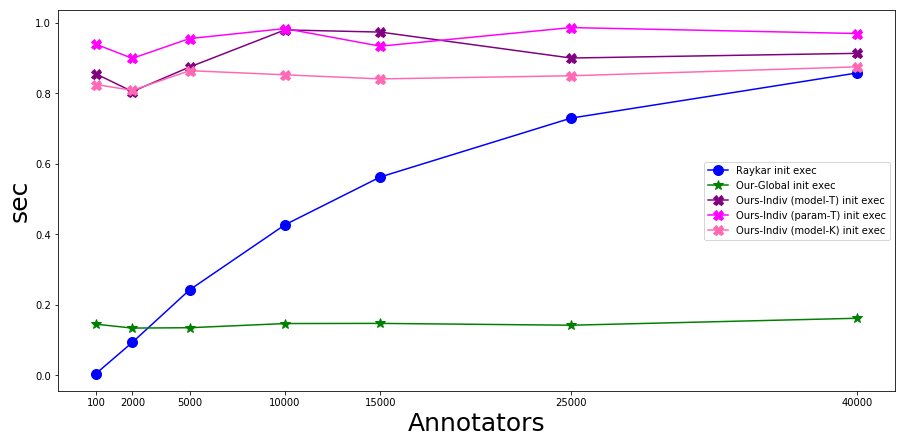

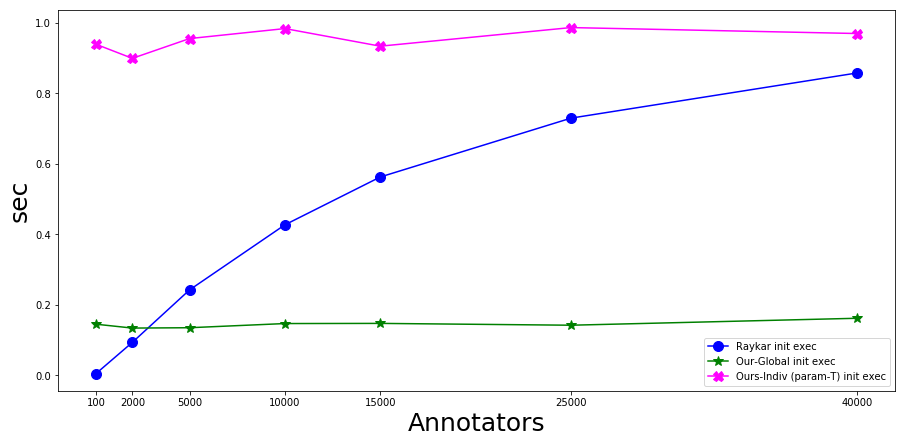

In [10]:
plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_init,'bo-',label="Raykar init exec", markersize=ms)
plt.plot(to_check,ourglobal_init,'g*-',label="Our-Global init exec", markersize=ms)
plt.plot(to_check,ourindiv1_init,'X-',label="Ours-Indiv (model-T) init exec", color='purple', markersize=ms)
plt.plot(to_check,ourindiv2_init,'X-',label="Ours-Indiv (param-T) init exec", color='magenta', markersize=ms)
plt.plot(to_check,ourindiv3_init,'X-',label="Ours-Indiv (model-K) init exec", color='hotpink', markersize=ms)

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_init,'bo-',label="Raykar init exec", markersize=ms)
plt.plot(to_check,ourglobal_init,'g*-',label="Our-Global init exec", markersize=ms)
plt.plot(to_check,ourindiv2_init,'X-',label="Ours-Indiv (param-T) init exec", color='magenta', markersize=ms)

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


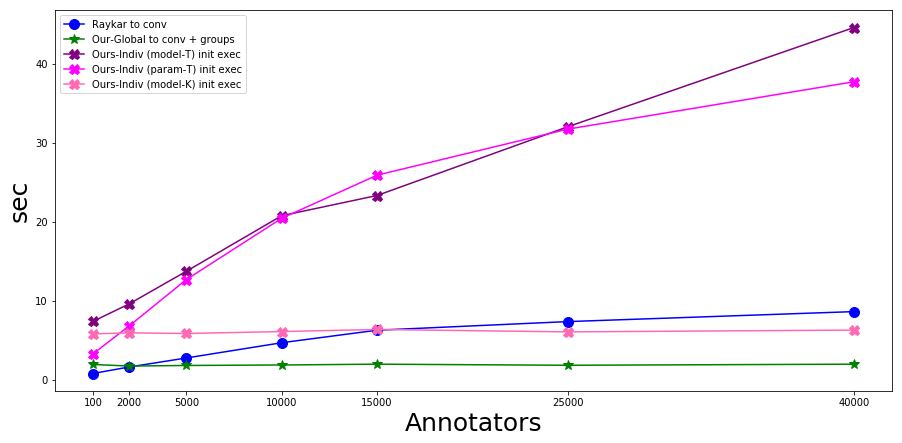

In [11]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 15
Our_iter = 25
Our_iter2 = 20

plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'bo-',label="Raykar to conv", markersize=ms)
plt.plot(to_check,ourglobal_init+ourglobal_exec*Our_iter,'g*-',label="Our-Global to conv + groups", markersize=ms) 

plt.plot(to_check,ourindiv1_init+ourindiv1_exec*Our_iter2,'X-',label="Ours-Indiv (model-T) init exec", color='purple', markersize=ms)
plt.plot(to_check,ourindiv2_init+ourindiv2_exec*Our_iter2,'X-',label="Ours-Indiv (param-T) init exec", color='magenta', markersize=ms)
plt.plot(to_check,ourindiv3_init+ourindiv3_exec*Our_iter2,'X-',label="Ours-Indiv (model-K) init exec", color='hotpink', markersize=ms)

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

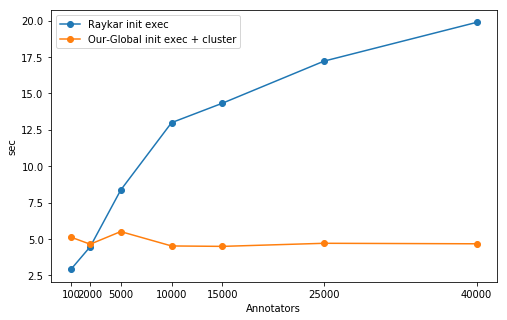

In [7]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 40
Our_iter = 40

plt.figure(figsize=(8,5))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'o-',label="Raykar init exec")
plt.plot(to_check,ourglobal_init+0.0021*60+ourglobal_exec*Our_iter,'o-',label="Our-Global init exec + groups")
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

### Future comparison
---

Simple Data


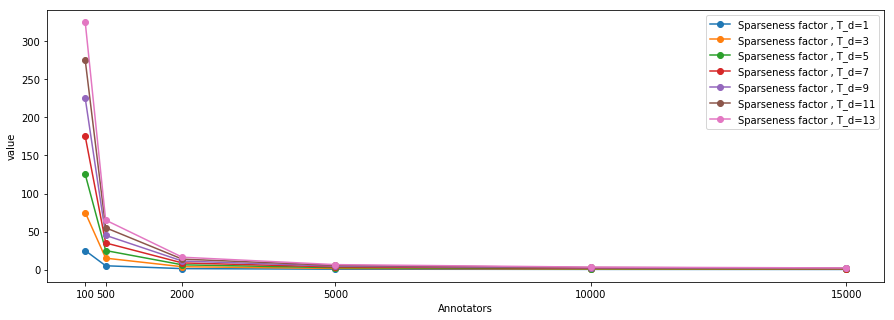

CIFAR Data


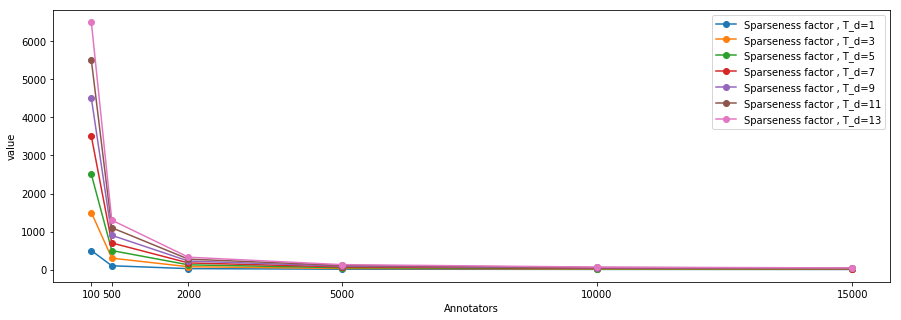

In [22]:
to_check = [100,500,2000,5000,10000,15000]
print("Simple Data")
N = 2500

T_data_test = np.arange(1,15,2)

plt.figure(figsize=(15,5))
for T_data in T_data_test:
    #fixint T_data
    D_t = [N*T_data/T for T in to_check]
    plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()

print("CIFAR Data")
N = 50000

T_data_test = np.arange(1,15,2)

plt.figure(figsize=(15,5))
for T_data in T_data_test:
    #fixint T_data
    D_t = [N*T_data/T for T in to_check]
    plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()

Simple Data


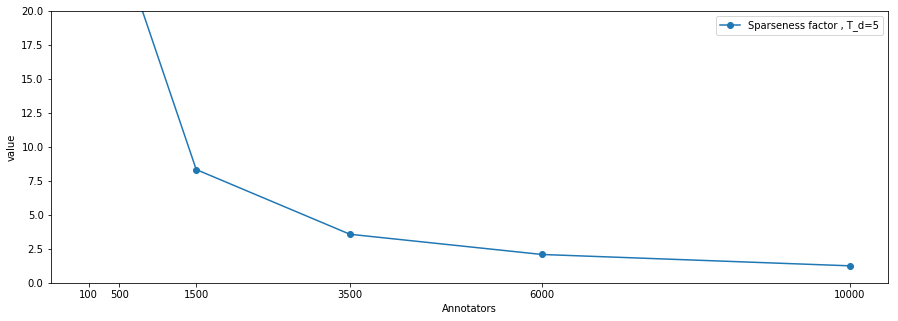

CIFAR Data


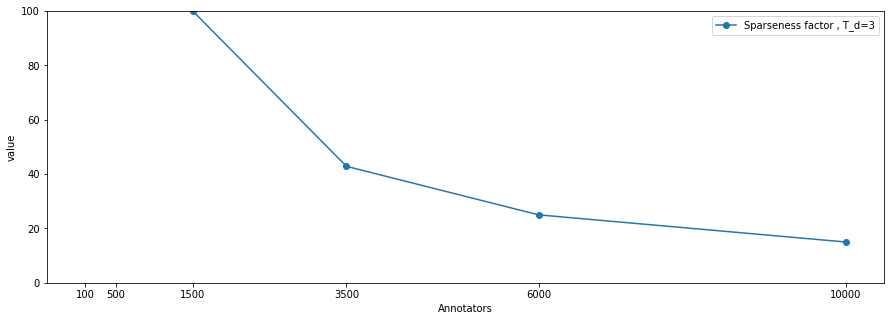

In [54]:
to_check = [100,500,1500,3500,6000,10000]
print("Simple Data")
N = 2500

plt.figure(figsize=(15,5))
T_data = 5 #5 para llegar solo a 10k o 10 para llegar a 15k
D_t = [N*T_data/T for T in to_check]
plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.ylim(0,20)

plt.show()

print("CIFAR Data")
N = 50000
T_data = 3 #para poder ver sparness factor mas bajos..
plt.figure(figsize=(15,5))
D_t = [N*T_data/T for T in to_check]
plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.ylim(0,100)
plt.show()

In [46]:
np.linspace(100,10000,6)

array([  100.,  2080.,  4060.,  6040.,  8020., 10000.])

In [4]:
to_check = [25,100,500,2000,5000,10000]


T_d= 5


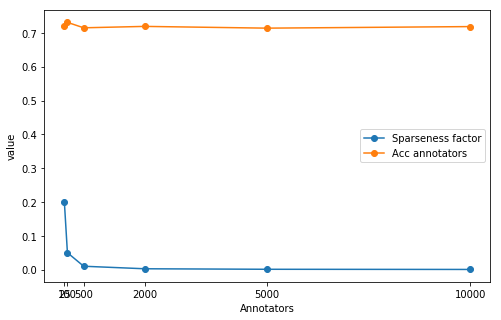

In [43]:
N = Z_train.shape[0]
#fixing T_d
T_data = 5
print("T_d=",T_data)
D_t = np.asarray([N*T_data/T for T in to_check])

annot_acc = []
for Tmax in to_check:
    aux = []
    for _ in range(10):
        y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)
        aux.append(np.mean(GenerateData.yo_label == Z_train))
    annot_acc.append(np.mean(aux))
    
plt.figure(figsize=(8,5))
plt.plot(to_check,D_t/N,'o-',label="Sparseness factor")
plt.plot(to_check,annot_acc,'o-',label="Acc annotators")
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()